In [2]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:

import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image

Create a database 

In [5]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [6]:

transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('images', transforms_) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:
dataloader

In [8]:
dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 7389
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Model


In [9]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
model

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Extracting features

In [10]:
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

In [11]:
# iterate over data
image_paths = []
descriptors = []
model.to(DEVICE)
with torch.no_grad():
    model.eval()
    for inputs, labels, paths in dataloader:
        result = pooling_output(inputs.to(DEVICE))
        descriptors.append(result.cpu().view(1, -1).numpy())
        image_paths.append(paths)
        torch.cuda.empty_cache()

In [12]:
import pickle

Ghi lại vào file


In [13]:
vector_file = "vectors.pkl"
path_file = "paths.pkl"
result_file = "results.pkl"


pickle.dump(image_paths, open(vector_file, "wb"))
pickle.dump(descriptors, open(path_file, "wb"))
pickle.dump(result, open(result_file , "wb"))


In [14]:
image_paths = pickle.load(open("vectors.pkl","rb"))
descriptors = pickle.load(open("paths.pkl","rb"))
result = pickle.load(open("results.pkl","rb"))



In [15]:
len(image_paths)

7389

In [16]:
image_paths[:5]

[('images\\abyssinian\\Abyssinian_1.jpg',),
 ('images\\abyssinian\\Abyssinian_10.jpg',),
 ('images\\abyssinian\\Abyssinian_100.jpg',),
 ('images\\abyssinian\\Abyssinian_101.jpg',),
 ('images\\abyssinian\\Abyssinian_102.jpg',)]

In [17]:
descriptors[0]

array([[0.6872339 , 0.30262476, 0.49835914, ..., 0.23650956, 0.1992047 ,
        0.05700836]], dtype=float32)

In [18]:
descriptors[0].shape

(1, 2048)

FAISS

In [19]:
pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install mkl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:

import numpy as np
import faiss


index = faiss.IndexFlatL2(2048)
descriptors = np.vstack(descriptors)
index.add(descriptors)

Query

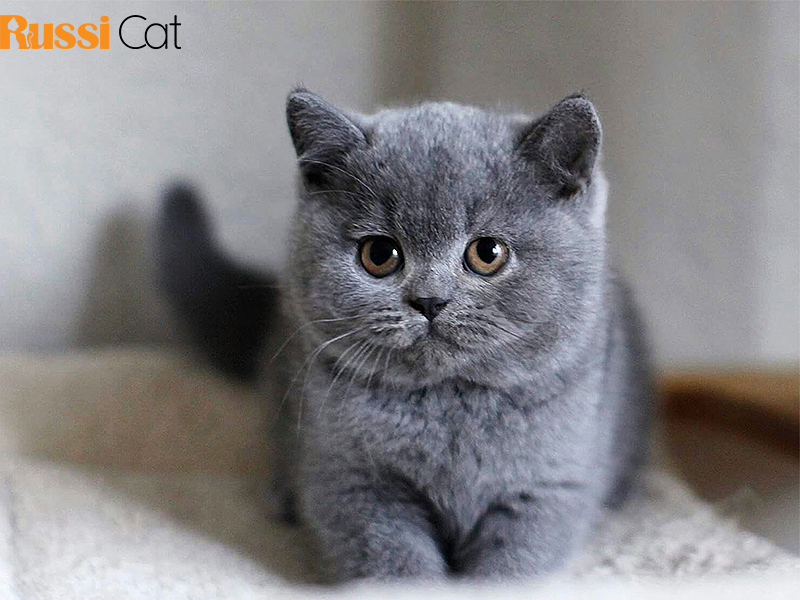

In [32]:
query_image = 'testimage/1conmeo.jpg'
img = Image.open(query_image)
img

In [33]:
input_tensor = transforms_(img)
input_tensor = input_tensor.view(1, *input_tensor.shape)
with torch.no_grad():
    query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
    distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)


In [34]:
distance


array([[131.51003, 146.50043, 168.43188, 169.88249, 171.15363, 171.395  ,
        172.88182, 173.98453, 174.39124]], dtype=float32)

In [35]:
indices

array([[1450, 1564, 1457, 1415, 1460, 1497, 1559, 1597, 1473]],
      dtype=int64)

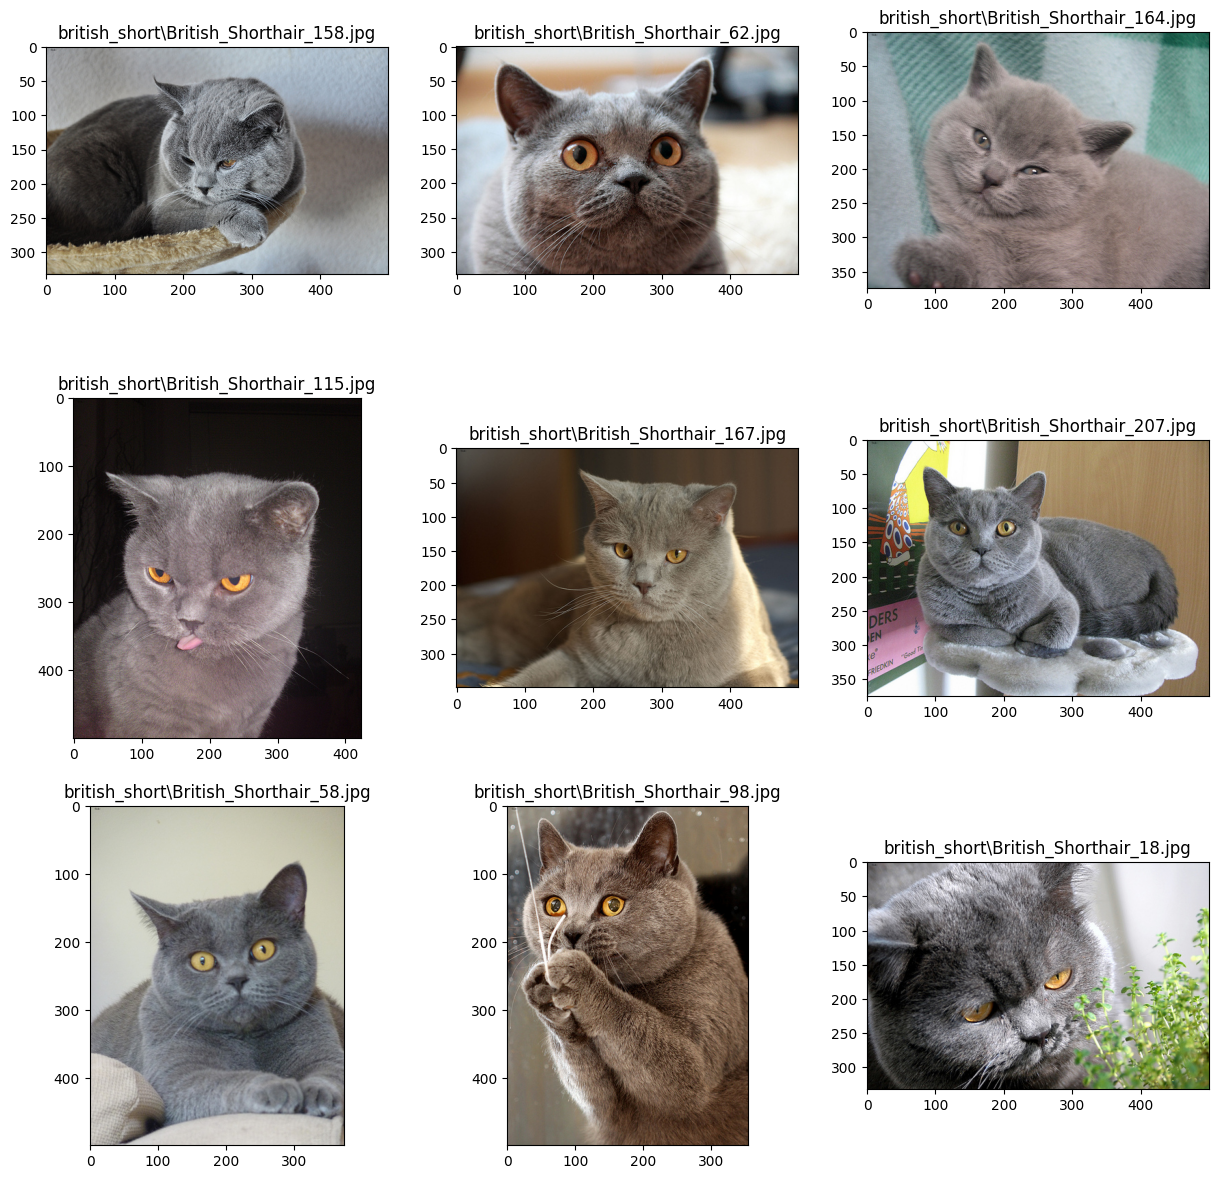

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    ax_i.set_title(image_paths[file_index][0][7:] )
    ax_i.imshow(plt.imread(image_paths[file_index][0]))
    
plt.show()